<a href="https://colab.research.google.com/github/manoel-nto/Logistic_Facilities_Distribution_Analysis/blob/main/1_data_collection_procedures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Procedimentos de coleta de dados



## 1.1 Preparando ambiente

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install contextily
!pip install folium
!pip install mapclassify

In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/spatial_distribution_logistic_facilities/'

## 1.2 Imports

In [ ]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

## 1.3 Empresas

### 1.3.1 Leitura dos dados

Devido ao grande volume de dados armazenados, a base da Receita Federal é disponibilizada de forma segregada, em diversos conjuntos de dados que, reunidos, formam a base completa.

Na leitura dos arquivos, foram mantidas apenas as colunas de interesse, com o CNPJ, a situação cadastral, a classificação de atividade econômica (CNAE) e os dados que compõem o endereço das empresas.

In [ ]:
# Total de colunas nas tabelas
columns = list(range(0, 30))

# Colunas de interesse
k_columns = [0, 1, 2, 5, 11, 14, 17, 18, 19]

# Abrindo arquivos zip com as tabelas (dados do dia: 08/10/2023)
list1 = []
for i in range(1, 11):
    chunk = pd.read_csv(
        f'data/{i}_estabelecimentos.zip',
        header=None,
        delimiter=';',
        encoding = 'latin1',
        on_bad_lines='skip',
        chunksize=1000000,
        low_memory=False,
        names=columns,
        usecols=k_columns
    )
    list1.append(chunk)

### 1.3.2 Nomeando colunas e filtrando dados

Cada uma das tabelas foi nomeada adequadamente e foram mantidos apenas os cadastros ativos de empresas localizadas no Distrito Federal.

In [ ]:
# Renomeando colunas e filtrando dados (UF == DF e Situação Cadastral == 2, ativa)
list2 = []
for i in range(0, 10):
    # Criar DataFrame
    companies_df = pd.concat(list1[i])

    # Renomear colunas
    companies_df.rename(
        columns={
            0:'cnpj_basico',
            1:'cnpj_ordem',
            2:'cnpj_dv',
            5:'situacao_cadastral',
            11:'cnae_fiscal_principal',
            14:'logradouro',
            17:'bairro',
            18:'cep',
            19:'uf'
        },
        inplace=True
    )

    # Manter somente cadastros ativos e do Distrito Federal (DF)
    companies_df = companies_df.loc[(companies_df['situacao_cadastral']==2) & (companies_df['uf']=='DF')]

    list2.append(companies_df)

In [ ]:
companies_df = pd.concat(list2)

In [ ]:
# Empresas do DF
companies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417213 entries, 40 to 4753427
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   cnpj_basico            417213 non-null  int64 
 1   cnpj_ordem             417213 non-null  int64 
 2   cnpj_dv                417213 non-null  int64 
 3   situacao_cadastral     417213 non-null  int64 
 4   cnae_fiscal_principal  417213 non-null  int64 
 5   logradouro             417037 non-null  object
 6   bairro                 417071 non-null  object
 7   cep                    417213 non-null  object
 8   uf                     417213 non-null  object
dtypes: int64(5), object(4)
memory usage: 31.8+ MB


### 1.3.3 Obtendo o CNPJ

As partes que compõem o CNPJ estão em três colunas diferentes: cnpj_basico, cnpj_ordem e cnpj_df. Desse modo, essas três colunas foram concatenadas para formar a coluna com o CNPJ das empresas.

In [ ]:
# Formatar componentes do CNPJ

# Dígitos 1-8
companies_df['cnpj_basico'] = companies_df['cnpj_basico'].apply(lambda x: str('{0:0>8}'.format(x)))

# Dígitos 9-12
companies_df['cnpj_ordem'] = companies_df['cnpj_ordem'].apply(lambda x: str('{0:0>4}'.format(x)))

# Dígitos 13-14
companies_df['cnpj_dv'] = companies_df['cnpj_dv'].apply(lambda x: str('{0:0>2}'.format(x)))

# Criar coluna CNPJ
cnpj = companies_df['cnpj_basico'] + companies_df['cnpj_ordem'] + companies_df['cnpj_dv']
companies_df.insert(
    loc=0,
    column='cnpj',
    value=cnpj
)

# Retirar colunas antigas
companies_df = companies_df.loc[:, ~companies_df.columns.isin(['cnpj_basico', 'cnpj_ordem', 'cnpj_dv'])].copy()

In [ ]:
companies_df.head()

cnpj  situacao_cadastral  cnae_fiscal_principal  \
40   13971127000108                   2                6110803   
364  14008368000100                   2                3101200   
421  14014921000118                   2                9521500   
426  14015479000144                   2                8650002   
663  14043027000176                   2                1412602   

                     logradouro                     bairro         cep  uf  
40      SHN BL J SOBRELOJAS 205                  ASA NORTE  70702909.0  DF  
364   SMPW QUADRA 13 CONJUNTO 7  SETOR DE MANSOES PARK WAY  71741307.0  DF  
421           QR 209 CONJUNTO N                SANTA MARIA  72509414.0  DF  
426                       SRTVS                    ASA SUL  70340000.0  DF  
663  QUADRA 1 AREA ESPECIAL S/N         SETOR NORTE (GAMA)  72430115.0  DF

### 1.3.4 Verificando CNPJ duplicados e removendo valores nulos

In [ ]:
# Verificar CNPJ duplicados
companies_df.duplicated().sum()

0

In [ ]:
# Verificar valores nulos
companies_df.isnull().sum()

cnpj                       0
situacao_cadastral         0
cnae_fiscal_principal      0
logradouro               176
bairro                   142
cep                        0
uf                         0
dtype: int64

In [ ]:
# Removendo linhas com valores nulos
companies_df.dropna(axis=0, inplace=True)
companies_df.isnull().sum()

cnpj                     0
situacao_cadastral       0
cnae_fiscal_principal    0
logradouro               0
bairro                   0
cep                      0
uf                       0
dtype: int64

In [ ]:
companies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416895 entries, 40 to 4753427
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   cnpj                   416895 non-null  object
 1   situacao_cadastral     416895 non-null  int64 
 2   cnae_fiscal_principal  416895 non-null  int64 
 3   logradouro             416895 non-null  object
 4   bairro                 416895 non-null  object
 5   cep                    416895 non-null  object
 6   uf                     416895 non-null  object
dtypes: int64(2), object(5)
memory usage: 25.4+ MB


### 1.3.5 Formatando o CEP

In [ ]:
# Converter cep para string
companies_df['cep'] = companies_df['cep'].apply(lambda x: str(int(x)))

# Formatar: XXXXX-XXX
companies_df['cep'] = companies_df['cep'].apply(lambda x: x[:5] + '-' + x[5:])

In [ ]:
companies_df.head()

cnpj  situacao_cadastral  cnae_fiscal_principal  \
40   13971127000108                   2                6110803   
364  14008368000100                   2                3101200   
421  14014921000118                   2                9521500   
426  14015479000144                   2                8650002   
663  14043027000176                   2                1412602   

                     logradouro                     bairro        cep  uf  
40      SHN BL J SOBRELOJAS 205                  ASA NORTE  70702-909  DF  
364   SMPW QUADRA 13 CONJUNTO 7  SETOR DE MANSOES PARK WAY  71741-307  DF  
421           QR 209 CONJUNTO N                SANTA MARIA  72509-414  DF  
426                       SRTVS                    ASA SUL  70340-000  DF  
663  QUADRA 1 AREA ESPECIAL S/N         SETOR NORTE (GAMA)  72430-115  DF

### 1.3.6 Filtrar empresas por tipo de atividade (CNAE)
Os códigos CNAE utilizados para selecionar empresas do setor de transporte e armazenamento foram os seguintes:
* 4930-2/01 - Transporte rodoviário de carga, exceto produtos perigosos e mudanças, municipal;
* 4930-2/02 - Transporte rodoviário de carga, exceto produtos perigosos e mudanças, intermunicipal, interestadual e internacional;
* 4930-2/03 - Transporte rodoviário de produtos perigosos;
* 5211-7/01 - Armazéns gerais - emissão de warrant;
* 5211-7/99 - Depósitos de mercadorias para terceiros, exceto armazéns gerais e guarda-móveis;
* 5212-5/00 - Carga e descarga;
* 5250-8/03 - Agenciamento de cargas, exceto para o transporte marítimo;
* 5250-8/04 - Organização logística do transporte de carga;
* 5250-8/05 - Operador de transporte multimodal – OTM.


In [ ]:
# Códigos CNAE
cnaes = {
    4930201:'Transporte rodoviário de carga, exceto produtos perigosos e mudanças, municipal',
    4930202:'Transporte rodoviário de carga, exceto produtos perigosos e mudanças, intermunicipal, interestadual e internacional',
    4930203:'Transporte rodoviário de produtos perigosos',
    5211701:'Armazéns gerais - emissão de warrant',
    5211799:'Depósitos de mercadorias para terceiros, exceto armazéns gerais e guarda-móveis',
    5212500:'Carga e descarga',
    5250803:'Agenciamento de cargas, exceto para o transporte marítimo',
    5250804:'Organização logística do transporte de carga',
    5250805:'Operador de transporte multimodal – OTM'
}

In [ ]:
# Filtrar empresas por CNAE
log_companies_df = companies_df[companies_df['cnae_fiscal_principal'].isin(list(cnaes.keys()))].copy()

log_companies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8338 entries, 14690 to 4697472
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   cnpj                   8338 non-null   object
 1   situacao_cadastral     8338 non-null   int64 
 2   cnae_fiscal_principal  8338 non-null   int64 
 3   logradouro             8338 non-null   object
 4   bairro                 8338 non-null   object
 5   cep                    8338 non-null   object
 6   uf                     8338 non-null   object
dtypes: int64(2), object(5)
memory usage: 521.1+ KB


### 1.3.7 Empresas por tipo de atividade: tabela de frequências

In [ ]:
cnaes_df = log_companies_df.groupby('cnae_fiscal_principal', as_index=False)['cnpj'].count()

cnaes_df.insert(
    loc=1,
    column='descricao',
    value=cnaes.values()
)

cnaes_df.rename(
    columns={'cnpj':'frequencia_absoluta'},
    inplace=True
)

cnaes_df['frequencia_relativa'] = round(cnaes_df['frequencia_absoluta'] / cnaes_df['frequencia_absoluta'].sum(), 4)

cnaes_df.sort_values(
    by='frequencia_absoluta',
    ascending=False,
    inplace=True
)

cnaes_df

cnae_fiscal_principal                                          descricao  \
0                4930201  Transporte rodoviário de carga, exceto produto...   
1                4930202  Transporte rodoviário de carga, exceto produto...   
5                5212500                                   Carga e descarga   
2                4930203        Transporte rodoviário de produtos perigosos   
4                5211799  Depósitos de mercadorias para terceiros, excet...   
3                5211701               Armazéns gerais - emissão de warrant   
7                5250804       Organização logística do transporte de carga   
6                5250803  Agenciamento de cargas, exceto para o transpor...   
8                5250805            Operador de transporte multimodal – OTM   

   frequencia_absoluta  frequencia_relativa  
0                 5197               0.6233  
1                 2371               0.2844  
5                  390               0.0468  
2                  141               0.0169  
4                   83               0.0100  
3                   63               0.0076  
7                   54               0.0065  
6                   30               0.0036  
8                    9               0.0011

### 1.3.8 Obtendo o endereço
O endereço completo é composto pelos valores das seguintes colunas: logradouro, bairro e cep.

In [ ]:
log_companies_df.reset_index(drop=True, inplace=True)

In [ ]:
log_companies_df.head()

cnpj  situacao_cadastral  cnae_fiscal_principal  \
0  05476044000882                   2                4930202   
1  20147617004139                   2                4930202   
2  15567321000140                   2                4930201   
3  15659259000116                   2                4930201   
4  15759496000159                   2                4930202   

           logradouro                                     bairro        cep  \
0  BR 020 KM 36  SALA                                 PLANALTINA  73091-010   
1     ST.G SUL CSG 12                TAGUATINGA SUL (TAGUATINGA)  72035-513   
2   QNM 36 CONJUNTO A              TAGUATINGA NORTE (TAGUATINGA)  72145-601   
3               CSB 3                TAGUATINGA SUL (TAGUATINGA)  72015-535   
4     RUA 10 MODULO 5  CONDOMINIO PRIVE LUCENA RORIZ (CEILANDIA)  72280-560   

   uf  
0  DF  
1  DF  
2  DF  
3  DF  
4  DF

In [ ]:
# Criar coluna com o endereço completo
log_companies_df['endereco'] = log_companies_df['logradouro'].copy() + ', ' + log_companies_df['bairro'].copy() + ', ' + 'Brasília - DF' + ', ' + log_companies_df['cep'].copy()

# Excluindo colunas antigas
log_companies_df = log_companies_df.loc[:, ~log_companies_df.columns.isin(['logradouro', 'bairro'])].copy()

log_companies_df.head()

cnpj  situacao_cadastral  cnae_fiscal_principal        cep  uf  \
0  05476044000882                   2                4930202  73091-010  DF   
1  20147617004139                   2                4930202  72035-513  DF   
2  15567321000140                   2                4930201  72145-601  DF   
3  15659259000116                   2                4930201  72015-535  DF   
4  15759496000159                   2                4930202  72280-560  DF   

                                            endereco  
0  BR 020 KM 36  SALA, PLANALTINA, Brasília - DF,...  
1  ST.G SUL CSG 12, TAGUATINGA SUL (TAGUATINGA), ...  
2  QNM 36 CONJUNTO A, TAGUATINGA NORTE (TAGUATING...  
3  CSB 3, TAGUATINGA SUL (TAGUATINGA), Brasília -...  
4  RUA 10 MODULO 5, CONDOMINIO PRIVE LUCENA RORIZ...

## 1.4 Limites das Regiões Administrativas (RA)

### 1.4.1 Leitura dos dados

In [ ]:
ras = gpd.read_file(
    'data/11_regioes_administrativas.zip',
    encoding='utf-8'
)

In [ ]:
ras.head()

ra_cira       ra_nome ra_codigo  \
0        1  PLANO PILOTO      RA-I   
1        2          GAMA     RA-II   
2        4    BRAZLÂNDIA     RA-IV   
3        5    SOBRADINHO      RA-V   
4        9     CEILÂNDIA     RA-IX   

                                             ra_path    st_area_sh  \
0  https://www.geoservicos1.segeth.df.gov.br/anex...  4.372014e+08   
1  https://www.geoservicos1.segeth.df.gov.br/anex...  2.754143e+08   
2  https://www.geoservicos1.segeth.df.gov.br/anex...  4.701836e+08   
3  https://www.geoservicos1.segeth.df.gov.br/anex...  1.935265e+08   
4  https://www.geoservicos1.segeth.df.gov.br/anex...  1.926569e+08   

      st_length_                                           geometry  
0  184204.574473  POLYGON ((193478.148 8263481.141, 193477.162 8...  
1   88879.970482  POLYGON ((168705.252 8236087.450, 168711.503 8...  
2  107050.466657  POLYGON ((174420.081 8280562.021, 174439.604 8...  
3  102972.805688  POLYGON ((203513.962 8281431.436, 203513.986 8...  
4  117499.507891  POLYGON ((159451.527 8256079.011, 159529.189 8...

In [ ]:
ras.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ra_cira     35 non-null     int64   
 1   ra_nome     35 non-null     object  
 2   ra_codigo   35 non-null     object  
 3   ra_path     35 non-null     object  
 4   st_area_sh  35 non-null     float64 
 5   st_length_  35 non-null     float64 
 6   geometry    35 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 2.0+ KB


In [ ]:
# Sistema de coordenadas
ras.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### 1.4.2 Mapa do DF

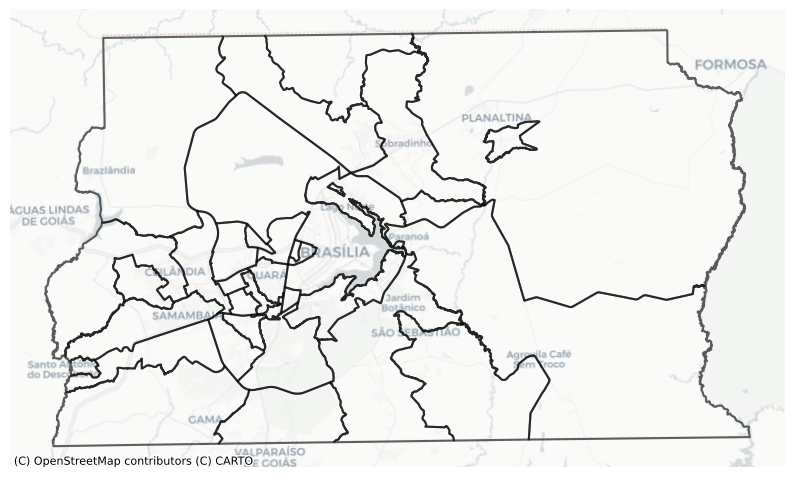

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 8))

# Limites das RA
ras.boundary.plot(
    ax=ax,
    edgecolor='k',
    alpha=0.6
)

# Adicinando base
ctx.add_basemap(
    ax=ax,
    source=ctx.providers.CartoDB.Positron,
    crs=ras.crs.to_string()
)

# Remover axis
ax.set_axis_off()

# Plot
plt.show()

## 1.5 Zoneamento do DF

### 1.5.1 Leitura dos dados

In [ ]:
zoning = gpd.read_file(
    'data/12_zoneamento_distrito_federal.zip',
    encoding='utf-8'
)

In [ ]:
zoning.head()

macrozona                         macroarea  \
0                 MACROZONA RURAL   ZONA RURAL DE USO DIVERSIFICADO   
1                 MACROZONA RURAL      ZONA RURAL DE USO CONTROLADO   
2                MACROZONA URBANA   ZONA URBANA DO CONJUNTO TOMBADO   
3  MACROZONA DE PROTEÇÃO INTEGRAL    MACROZONA DE PROTEÇÃO INTEGRAL   
4                MACROZONA URBANA  ZONA URBANA DE USO CONTROLADO II   

          sigla emendas      area_km        area_ha    st_area_sh  \
0          ZRUD    None  1406.979828  140697.982841  1.406982e+09   
1      ZRUC - 1    None   930.892349   93089.234910  9.765345e+08   
2          ZUCT    None   150.867089   15086.708927  1.508673e+08   
3       MPI - 7    None    81.227630    8122.763027  8.122775e+07   
4  ZUUC II - 11    None    10.871042    1087.104159  1.087106e+07   

      st_length_                                           geometry  
0  255959.209735  POLYGON ((241070.587 8279616.874, 241095.587 8...  
1  477622.935721  POLYGON ((169970.200 8282964.838, 169878.200 8...  
2  100174.573179  POLYGON ((193739.058 8259470.040, 193747.408 8...  
3   68505.972386  POLYGON ((195371.597 8242215.647, 195379.477 8...  
4   17201.953025  POLYGON ((169708.984 8250509.082, 169876.114 8...

In [ ]:
zoning['area_km'].sum()

5678.190833399999

In [ ]:
sum(zoning['geometry'].area / 1000000)

5790.103459601682

In [ ]:
# Sistema de coordenadas
zoning.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### 1.5.2 Mapa do DF com zoneamento

In [ ]:
zoning.explore(
    column='macroarea',
    tiles='CartoDB Positron',
)

## 1.6 Localização das empresas


### 1.6.1 Geocodificando endereços

Para que fosse possível confecionar mapas e calcular medidas de distância e associação espacial, o endereço das empresas foi "convertido" em coordenadas geográficas.

In [ ]:
# Geocodificar endereços
addresses_gdf = gpd.tools.geocode(
    log_companies_df['endereco'],
    provider='arcgis',
    timeout=1
)

In [ ]:
addresses_gdf.head()

address  \
0  KM 36 BR-020, Planaltina, Distrito Federal, 73355   
1            72035-513, Taguatinga, Distrito Federal   
2  Qnm 36 Conjunto a, Setor M Norte, Taguatinga, ...   
3  Csb, Setor B Sul, Taguatinga, Distrito Federal...   
4  Condomínio Prive Lucena Roriz, Ceilândia, Dist...   

                      geometry  
0  POINT (-47.54999 -15.58168)  
1  POINT (-48.03132 -15.87179)  
2  POINT (-48.09612 -15.80760)  
3  POINT (-48.05078 -15.84254)  
4  POINT (-48.13716 -15.78545)

In [ ]:
addresses_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8338 entries, 0 to 8337
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   address   8335 non-null   object  
 1   geometry  8335 non-null   geometry
dtypes: geometry(1), object(1)
memory usage: 130.4+ KB


### 1.6.2 GeoDataFrame das empresas com endereços geocodificados

In [ ]:
# Juntar dados: empresas (RFB) + endereços (coordenadas)
companies_gdf = pd.concat(
    objs=[
        log_companies_df,
        addresses_gdf
    ],
    axis='columns'
)

# Criar GeoDataFrame
companies_gdf = gpd.GeoDataFrame(
    companies_gdf.copy(),
    geometry='geometry',
    crs=addresses_gdf.crs.to_string()
)

In [ ]:
companies_gdf.head()

cnpj  situacao_cadastral  cnae_fiscal_principal        cep  uf  \
0  05476044000882                   2                4930202  73091-010  DF   
1  20147617004139                   2                4930202  72035-513  DF   
2  15567321000140                   2                4930201  72145-601  DF   
3  15659259000116                   2                4930201  72015-535  DF   
4  15759496000159                   2                4930202  72280-560  DF   

                                            endereco  \
0  BR 020 KM 36  SALA, PLANALTINA, Brasília - DF,...   
1  ST.G SUL CSG 12, TAGUATINGA SUL (TAGUATINGA), ...   
2  QNM 36 CONJUNTO A, TAGUATINGA NORTE (TAGUATING...   
3  CSB 3, TAGUATINGA SUL (TAGUATINGA), Brasília -...   
4  RUA 10 MODULO 5, CONDOMINIO PRIVE LUCENA RORIZ...   

                                             address  \
0  KM 36 BR-020, Planaltina, Distrito Federal, 73355   
1            72035-513, Taguatinga, Distrito Federal   
2  Qnm 36 Conjunto a, Setor M Norte, Taguatinga, ...   
3  Csb, Setor B Sul, Taguatinga, Distrito Federal...   
4  Condomínio Prive Lucena Roriz, Ceilândia, Dist...   

                      geometry  
0  POINT (-47.54999 -15.58168)  
1  POINT (-48.03132 -15.87179)  
2  POINT (-48.09612 -15.80760)  
3  POINT (-48.05078 -15.84254)  
4  POINT (-48.13716 -15.78545)

In [ ]:
# Converter sistema de coordenadas
companies_gdf = companies_gdf.to_crs(ras.crs.to_string())

In [ ]:
companies_gdf.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### 1.6.3 Região Administrativa

Utilizou-se a função `overlay()` do GeoPandas para identifcar a RA onde cada uma das empresas está localizada. O mesmo se aplica ao próximo tópico (Zona)

In [ ]:
companies_ol_gdf = gpd.overlay(
    companies_gdf,
    ras,
    how='intersection'
)

In [ ]:
# 8327 empresas com endereços válidos
companies_ol_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8327 entries, 0 to 8326
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   cnpj                   8327 non-null   object  
 1   situacao_cadastral     8327 non-null   int64   
 2   cnae_fiscal_principal  8327 non-null   int64   
 3   cep                    8327 non-null   object  
 4   uf                     8327 non-null   object  
 5   endereco               8327 non-null   object  
 6   address                8327 non-null   object  
 7   ra_cira                8327 non-null   int64   
 8   ra_nome                8327 non-null   object  
 9   ra_codigo              8327 non-null   object  
 10  ra_path                8327 non-null   object  
 11  st_area_sh             8327 non-null   float64 
 12  st_length_             8327 non-null   float64 
 13  geometry               8327 non-null   geometry
dtypes: float64(2), geometry(1), int6

### 1.6.4 Zona (zoneamento)

In [ ]:
# Empresa, RA e Zona
companies_ol_gdf = gpd.overlay(
    companies_ol_gdf.copy(),
    zoning,
    how='intersection'
)

In [ ]:
companies_ol_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8327 entries, 0 to 8326
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   cnpj                   8327 non-null   object  
 1   situacao_cadastral     8327 non-null   int64   
 2   cnae_fiscal_principal  8327 non-null   int64   
 3   cep                    8327 non-null   object  
 4   uf                     8327 non-null   object  
 5   endereco               8327 non-null   object  
 6   address                8327 non-null   object  
 7   ra_cira                8327 non-null   int64   
 8   ra_nome                8327 non-null   object  
 9   ra_codigo              8327 non-null   object  
 10  ra_path                8327 non-null   object  
 11  st_area_sh_1           8327 non-null   float64 
 12  st_length__1           8327 non-null   float64 
 13  macrozona              8327 non-null   object  
 14  macroarea              8327 non-

## 1.7 Sistema viário: rodovias federais e distritais

### 1.7.1 Rodovias distritais

In [ ]:
# Arquivo com rodovias estaduais (Brasil)
state_highways = gpd.read_file(
    'data/13_rodovias_estaduais.zip',
    enconding='utf-8'
)

In [ ]:
state_highways.columns

Index(['ogc_fid', 'Codigo_Rod', 'Tipo_Trech', 'Unidade_Fe', 'Codigo_SNV',
       'Codigo_SRE', 'Local_Inic', 'Local_Fim', 'Quilometra', 'Quilom',
       'Extensao', 'Superficie', 'Tipo_Reves', 'Jurisdicao', 'Referencia',
       'geometry'],
      dtype='object')

In [ ]:
# Rodovias distritais (DF)
df_highways = state_highways.loc[(state_highways['Unidade_Fe']=='DF')]

In [ ]:
# Converter crs
df_highways = df_highways.copy().to_crs(ras.crs.to_string())

In [ ]:
df_highways.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### 1.7.2 Rodovias federais

In [ ]:
# Arquivo com rodovias federais (Brasil)
federal_highways = gpd.read_file(
    'data/14_rodovias_federais.zip',
    enconding='utf-8'
)

In [ ]:
federal_highways.columns

Index(['ogc_fid', 'id_trecho_', 'vl_br', 'sg_uf', 'nm_tipo_tr', 'sg_tipo_tr',
       'desc_coinc', 'vl_codigo', 'ds_local_i', 'ds_local_f', 'vl_km_inic',
       'vl_km_fina', 'vl_extensa', 'ds_sup_fed', 'ds_obra', 'ul', 'ds_coinc',
       'ds_tipo_ad', 'ds_ato_leg', 'est_coinc', 'sup_est_co', 'ds_jurisdi',
       'ds_superfi', 'ds_legenda', 'sg_legenda', 'leg_multim', 'versao_snv',
       'id_versao', 'marcador', 'geometry'],
      dtype='object')

In [ ]:
# Rodovias federais (DF)
df_federal_highways = federal_highways.loc[(federal_highways['sg_uf']=='DF')]

In [ ]:
# Converter crs
df_federal_highways = df_federal_highways.to_crs(ras.crs.to_string())

In [ ]:
df_federal_highways.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### 1.7.3 Localização das rodovias por RA

In [ ]:
# Rodovias distritais + RA
df_highways_ras = gpd.overlay(
    df_highways,
    ras,
    how='intersection'
)

In [ ]:
df_highways_ras.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ogc_fid     712 non-null    int64   
 1   Codigo_Rod  557 non-null    object  
 2   Tipo_Trech  557 non-null    object  
 3   Unidade_Fe  712 non-null    object  
 4   Codigo_SNV  557 non-null    object  
 5   Codigo_SRE  557 non-null    object  
 6   Local_Inic  557 non-null    object  
 7   Local_Fim   557 non-null    object  
 8   Quilometra  564 non-null    float64 
 9   Quilom      564 non-null    float64 
 10  Extensao    564 non-null    float64 
 11  Superficie  557 non-null    object  
 12  Tipo_Reves  362 non-null    object  
 13  Jurisdicao  557 non-null    object  
 14  Referencia  712 non-null    object  
 15  ra_cira     712 non-null    int64   
 16  ra_nome     712 non-null    object  
 17  ra_codigo   712 non-null    object  
 18  ra_path     712 non-null    object  
 19  

In [ ]:
# Rodovias federais + RA
df_federal_highways_ras = gpd.overlay(df_federal_highways, ras, how='intersection')

In [ ]:
df_federal_highways_ras.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ogc_fid     156 non-null    int64   
 1   id_trecho_  156 non-null    float64 
 2   vl_br       156 non-null    object  
 3   sg_uf       156 non-null    object  
 4   nm_tipo_tr  156 non-null    object  
 5   sg_tipo_tr  156 non-null    object  
 6   desc_coinc  156 non-null    object  
 7   vl_codigo   156 non-null    object  
 8   ds_local_i  156 non-null    object  
 9   ds_local_f  156 non-null    object  
 10  vl_km_inic  156 non-null    float64 
 11  vl_km_fina  156 non-null    float64 
 12  vl_extensa  156 non-null    float64 
 13  ds_sup_fed  156 non-null    object  
 14  ds_obra     0 non-null      object  
 15  ul          99 non-null     object  
 16  ds_coinc    156 non-null    object  
 17  ds_tipo_ad  156 non-null    object  
 18  ds_ato_leg  0 non-null      object  
 19  

### 1.7.4 Extensão de rodovias por RA

Para otenção da extensão de rodovias (km) presente em cada RA, utilizou-se o `groupby()` com a função `sum()`. Em seguida, aplicou-se o `merge()` para "unir" os dados de rodovias distritais e federais.

In [ ]:
# Calcular a extensão das rodovias distritais em km
df_highways_ras['s_km_length'] = df_highways_ras['geometry'].length/1000

# DataFrame extensão por RA
length_s_highways = df_highways_ras.groupby(['ra_cira', 'ra_nome'], as_index=False)['s_km_length'].sum(numeric_only=True)

length_s_highways.head()

ra_cira       ra_nome  s_km_length
0        1  PLANO PILOTO    70.564294
1        2          GAMA   111.089369
2        3    TAGUATINGA    18.327657
3        4    BRAZLÂNDIA   178.283581
4        5    SOBRADINHO    63.820064

In [ ]:
# Extensão total das rodovias distritais em km
round(length_s_highways['s_km_length'].sum(), 2)

1943.78

In [ ]:
# Calcular a extensão das rodovias federais em km
df_federal_highways_ras['f_km_length'] = df_federal_highways_ras['geometry'].length/1000

# DataFrame extensão por RA
length_f_highways = df_federal_highways_ras.groupby(['ra_cira', 'ra_nome'], as_index=False)['f_km_length'].sum(numeric_only=True)

length_f_highways.head()

ra_cira       ra_nome  f_km_length
0        1  PLANO PILOTO     9.642174
1        2          GAMA    34.380280
2        3    TAGUATINGA     6.319330
3        4    BRAZLÂNDIA    68.998746
4        5    SOBRADINHO    38.065878

In [ ]:
# Extensão total das rodovias federais em km
round(length_f_highways['f_km_length'].sum(), 2)

512.37

In [ ]:
df_highways = pd.merge(
    length_s_highways,
    length_f_highways,
    how='left',
    on=['ra_cira', 'ra_nome']
)

In [ ]:
df_highways.fillna(0, inplace=True)

In [ ]:
df_highways['total_h_length'] = df_highways['s_km_length'] + df_highways['f_km_length']

df_highways.head()

ra_cira       ra_nome  s_km_length  f_km_length  total_h_length
0        1  PLANO PILOTO    70.564294     9.642174       80.206468
1        2          GAMA   111.089369    34.380280      145.469649
2        3    TAGUATINGA    18.327657     6.319330       24.646987
3        4    BRAZLÂNDIA   178.283581    68.998746      247.282327
4        5    SOBRADINHO    63.820064    38.065878      101.885943

In [ ]:
final_ras = ras.merge(
    df_highways,
    how='left',
    on=['ra_cira', 'ra_nome']
)

In [ ]:
final_ras.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 35 entries, 0 to 34
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ra_cira         35 non-null     int64   
 1   ra_nome         35 non-null     object  
 2   ra_codigo       35 non-null     object  
 3   ra_path         35 non-null     object  
 4   st_area_sh      35 non-null     float64 
 5   st_length_      35 non-null     float64 
 6   geometry        35 non-null     geometry
 7   s_km_length     35 non-null     float64 
 8   f_km_length     35 non-null     float64 
 9   total_h_length  35 non-null     float64 
dtypes: float64(5), geometry(1), int64(1), object(3)
memory usage: 3.0+ KB


### 1.7.5 Total de empresas por RA

In [ ]:
# Utilizando o groupby() e merge() para obtenção do total de empresas presentes em cada RA.
obj2 = companies_ol_gdf.groupby(['ra_cira', 'ra_nome'], as_index=False)['cnpj'].count()
final_ras = final_ras.merge(
    obj2,
    how='left',
    on=['ra_cira', 'ra_nome']
)

In [ ]:
final_ras.head()

ra_cira       ra_nome ra_codigo  \
0        1  PLANO PILOTO      RA-I   
1        2          GAMA     RA-II   
2        4    BRAZLÂNDIA     RA-IV   
3        5    SOBRADINHO      RA-V   
4        9     CEILÂNDIA     RA-IX   

                                             ra_path    st_area_sh  \
0  https://www.geoservicos1.segeth.df.gov.br/anex...  4.372014e+08   
1  https://www.geoservicos1.segeth.df.gov.br/anex...  2.754143e+08   
2  https://www.geoservicos1.segeth.df.gov.br/anex...  4.701836e+08   
3  https://www.geoservicos1.segeth.df.gov.br/anex...  1.935265e+08   
4  https://www.geoservicos1.segeth.df.gov.br/anex...  1.926569e+08   

      st_length_                                           geometry  \
0  184204.574473  POLYGON ((193478.148 8263481.141, 193477.162 8...   
1   88879.970482  POLYGON ((168705.252 8236087.450, 168711.503 8...   
2  107050.466657  POLYGON ((174420.081 8280562.021, 174439.604 8...   
3  102972.805688  POLYGON ((203513.962 8281431.436, 203513.986 8...   
4  117499.507891  POLYGON ((159451.527 8256079.011, 159529.189 8...   

   s_km_length  f_km_length  total_h_length  cnpj  
0    70.564294     9.642174       80.206468   351  
1   111.089369    34.380280      145.469649   412  
2   178.283581    68.998746      247.282327   139  
3    63.820064    38.065878      101.885943   163  
4    45.296380    31.879428       77.175808  1391

### 1.7.6 Area e variáveis espaciais intensivas

Uma variável espacial intensiva sumariza um atributo para um determinado objeto espacial. Assim, foram calculadas, para as RA, as seguintes variáveis: "*densidade de empresas*" e "*densidade de rede viária*". Estas foram as variáveis utilizadas na análise de autocorrelação espacial.

In [ ]:
# Calculando área das RA
final_ras['ra_area_km2'] = final_ras['geometry'].area / 1000000

# Calculando empresas por quilômetro quadrado (densidade de empresas)
final_ras['companies_km2'] = final_ras['cnpj'] / final_ras['ra_area_km2']

# Calculando rodovias por quilômetro quadrado (densidade de rede viária)
final_ras['highway_km2'] = final_ras['total_h_length'] / final_ras['ra_area_km2']

In [ ]:
final_ras.head()

ra_cira       ra_nome ra_codigo  \
0        1  PLANO PILOTO      RA-I   
1        2          GAMA     RA-II   
2        4    BRAZLÂNDIA     RA-IV   
3        5    SOBRADINHO      RA-V   
4        9     CEILÂNDIA     RA-IX   

                                             ra_path    st_area_sh  \
0  https://www.geoservicos1.segeth.df.gov.br/anex...  4.372014e+08   
1  https://www.geoservicos1.segeth.df.gov.br/anex...  2.754143e+08   
2  https://www.geoservicos1.segeth.df.gov.br/anex...  4.701836e+08   
3  https://www.geoservicos1.segeth.df.gov.br/anex...  1.935265e+08   
4  https://www.geoservicos1.segeth.df.gov.br/anex...  1.926569e+08   

      st_length_                                           geometry  \
0  184204.574473  POLYGON ((193478.148 8263481.141, 193477.162 8...   
1   88879.970482  POLYGON ((168705.252 8236087.450, 168711.503 8...   
2  107050.466657  POLYGON ((174420.081 8280562.021, 174439.604 8...   
3  102972.805688  POLYGON ((203513.962 8281431.436, 203513.986 8...   
4  117499.507891  POLYGON ((159451.527 8256079.011, 159529.189 8...   

   s_km_length  f_km_length  total_h_length  cnpj  ra_area_km2  companies_km2  \
0    70.564294     9.642174       80.206468   351   437.201382       0.802834   
1   111.089369    34.380280      145.469649   412   275.414324       1.495928   
2   178.283581    68.998746      247.282327   139   470.183559       0.295629   
3    63.820064    38.065878      101.885943   163   193.526477       0.842262   
4    45.296380    31.879428       77.175808  1391   192.656942       7.220088   

   highway_km2  
0     0.183454  
1     0.528185  
2     0.525927  
3     0.526470  
4     0.400587

## 1.8 Salvando datasets

### 1.8.1 Arquivos csv

In [ ]:
# Empresas no DF
companies_df.to_csv('data/15_companies_df.csv', index=False)

# Empresas no DF (logística)
log_companies_df.to_csv('data/16_log_companies_df.csv', index=False)

# Classificação CNAE
cnaes_df.to_csv('data/17_cnaes_df.csv', index=False)

### 1.8.2 *Geopackages*

In [ ]:
# Endereços
addresses_gdf.to_file(
    'data/18_addresses_gdf.gpkg',
    driver='GPKG',
    index=False
)

# Empresas (coordenadas, RA e Zona adicionados)
companies_ol_gdf.to_file(
    'data/19_companies_ol_gdf.gpkg',
    driver='GPKG',
    index=False
)

# Rodovias distritais
df_highways_ras.to_file(
    'data/20_df_highways_ras.gpkg',
    driver='GPKG',
    index=False
)

# Rodovias federais
df_federal_highways_ras.to_file(
    'data/21_df_federal_highways_ras.gpkg',
    driver='GPKG',
    index=False
)

# RA (densidade de empresas e de rede viária adicionados)
final_ras.to_file(
    'data/22_final_ras.gpkg',
    driver='GPKG',
    index=False
)